In [1]:
import io
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from matplotlib import rc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler,RobustScaler # for standardizing the Data
from sklearn.decomposition import PCA

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 7)})

In [2]:
covid19_csv = pd.read_csv('owid-covid-data.csv')
covid19_csv.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [3]:
covid19_df = covid19_csv[['location','date','total_cases','new_cases','total_deaths','new_deaths','population','population_density','aged_65_older','gdp_per_capita','cardiovasc_death_rate','diabetes_prevalence','life_expectancy']]
covid19_df.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths,population,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy
0,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
1,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
3,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
4,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83


In [4]:
# Converting the normally indexed dataframe to a time series indexed dataframe
covid19_df.index = pd.to_datetime(covid19_df['date'])
covid19_df = covid19_df.drop(columns=['date'])
covid19_df.head()

,location,total_cases,new_cases,total_deaths,new_deaths,population,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy
date,,,,,,,,,,,,
2019-12-31,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-01,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-02,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-03,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-04,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83


In [5]:
# Country dataframe creation

def country_dataset(country):

    grouped = covid19_df.groupby(covid19_df.location)
    df_country = grouped.get_group(country)
    df_country = df_country.dropna()
    df_country = df_country[df_country.total_cases != 0]
    df_country.head()
    
    return df_country
    
    ## df_all_selected_countries = covid19_df[covid19_df['location'].isin(['Canada','China','Italy','Mexico','Finland'])]
    ## df_all_selected_countries = pd.concat([df_all_selected_countries,pd.get_dummies(df_all_selected_countries['location'], prefix='country')],axis=1)
    ## df_all_selected_countries.drop(['location'],axis=1, inplace=True)
    ## df_all_selected_countries.head()

In [6]:
def predict_new_deaths(df):
    
    train_size = int(len(df) * 0.9)
    test_size = len(df) - train_size
    
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    print('Training rows :',len(train),' - Test rows', len(test))

    f_columns = ['total_cases','new_cases','total_deaths','new_deaths','population_density']

    f_transformer = RobustScaler()
    cnt_transformer = RobustScaler()

    f_transformer = f_transformer.fit(train[f_columns].to_numpy())
    cnt_transformer = cnt_transformer.fit(train[['new_deaths']])

    train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
    train['cnt'] = cnt_transformer.transform(train[['new_deaths']])

    test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
    test['cnt'] = cnt_transformer.transform(test[['new_deaths']])

    def create_dataset(X, y, time_steps=1):
        Xs, ys = [], []
        for i in range(len(X) - time_steps):
            v = X.iloc[i:(i + time_steps)].values
            Xs.append(v)
            ys.append(y.iloc[i + time_steps])
        return np.array(Xs), np.array(ys)

    time_steps = 5

    # reshape to [samples, time_steps, n_features]

    X_train, y_train = create_dataset(train, train.cnt, time_steps)
    X_test, y_test = create_dataset(test, test.cnt, time_steps)
    
    model = keras.Sequential()
    model.add(
        keras.layers.Bidirectional(
          keras.layers.LSTM(
            units=128, 
            input_shape=(X_train.shape[1], X_train.shape[2])
          )
        )
      )
    
    model.add(keras.layers.Dropout(rate=0.1))
    model.add(keras.layers.Dense(units=1))
    model.add(keras.layers.Dense(units=1))
    
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    batch_size = 1
    max_epochs = 1000
    early_stopping = tf.keras.callbacks.EarlyStopping(patience = 10)

    history = model.fit(
        X_train, y_train, 
        epochs=max_epochs, 
        batch_size=batch_size,
        callbacks = [early_stopping],
        validation_split=0.1,
        shuffle=False
      )    

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend();
    plt.show()
    
    y_pred = model.predict(X_test)

    y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
    y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
    y_pred_inv = cnt_transformer.inverse_transform(y_pred)

    plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
    plt.ylabel('Deaths per day')
    plt.xlabel('Time Step')
    plt.legend()
    plt.show();
    

In [7]:
def analyze(country):  

    print(country)
    df = country_dataset(country)    
    
    df['total_cases'].plot(color='#ffa500')
    df['total_deaths'].plot(color='#ff0000')   
    orange_patch = mpatches.Patch(color='#ffa500',label="Total Cases")
    red_patch = mpatches.Patch(color='#ff0000',label="Total Deaths")
    plt.legend(handles=[orange_patch, red_patch])
    plt.xlabel('Time Step')     
    plt.show()    
    
    df['new_cases'].plot(color='#ffa500')
    df['new_deaths'].plot(color='#ff0000')    
    orange_patch = mpatches.Patch(color='#ffa500',label="New Cases")
    red_patch = mpatches.Patch(color='#ff0000',label="New Deaths")
    plt.legend(handles=[orange_patch, red_patch])
    plt.xlabel('Time Step')    
    plt.show()
    
    #predict_daily_cases(df)
    #df = df[['population_density', 'aged_65_older', 'hospital_beds_per_100k', 'new_cases','new_deaths']]
    df = df[['total_cases','new_cases','total_deaths','new_deaths','population_density']]
    predict_new_deaths(df)

Canada


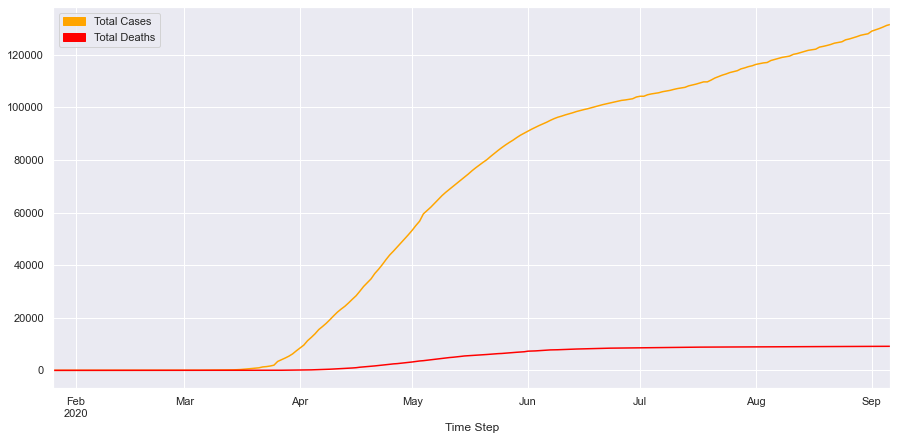

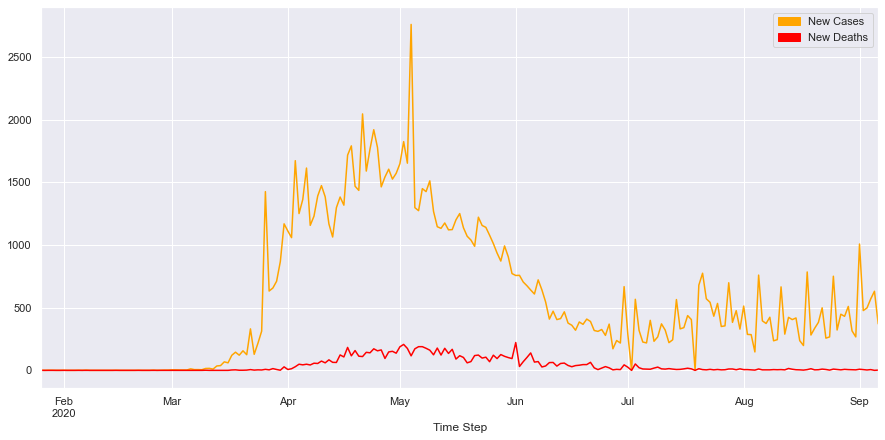

Training rows : 202  - Test rows 23


C:\Users\david\anaconda3\envs\py3-TF2\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\david\anaconda3\envs\py3-TF2\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\david\anaconda3\envs\py3-TF2\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

Epoch 1/1000
177/177 [==============================] - 1s 8ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 2/1000
177/177 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 3/1000
177/177 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 7.3312e-05
Epoch 4/1000
177/177 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 2.0756e-05
Epoch 5/1000
177/177 [==============================] - 0s 2ms/step - loss: 3.7035e-04 - val_loss: 3.2273e-05
Epoch 6/1000
177/177 [==============================] - 0s 2ms/step - loss: 2.8462e-04 - val_loss: 4.5289e-05
Epoch 7/1000
177/177 [==============================] - 0s 2ms/step - loss: 3.9345e-04 - val_loss: 1.2166e-05
Epoch 8/1000
177/177 [==============================] - 0s 2ms/step - loss: 2.8840e-04 - val_loss: 5.8565e-05
Epoch 9/1000
177/177 [==============================] - 0s 2ms/step - loss: 2.0348e-04 - val_loss: 2.1021e-05
Epoch 10/1000
177/177 [===========

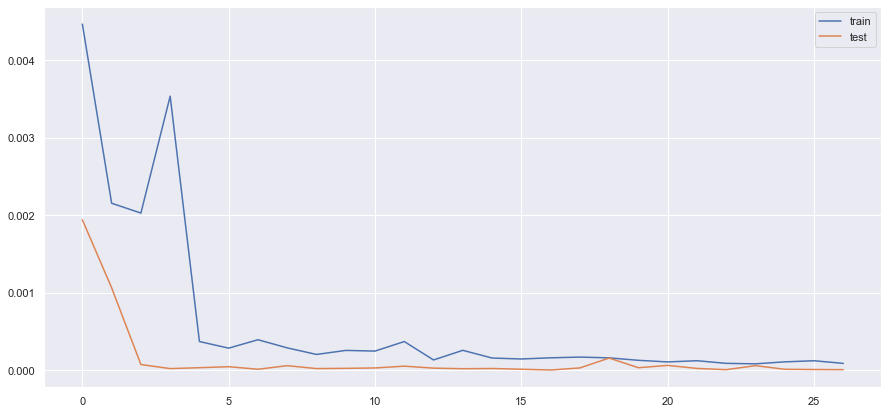

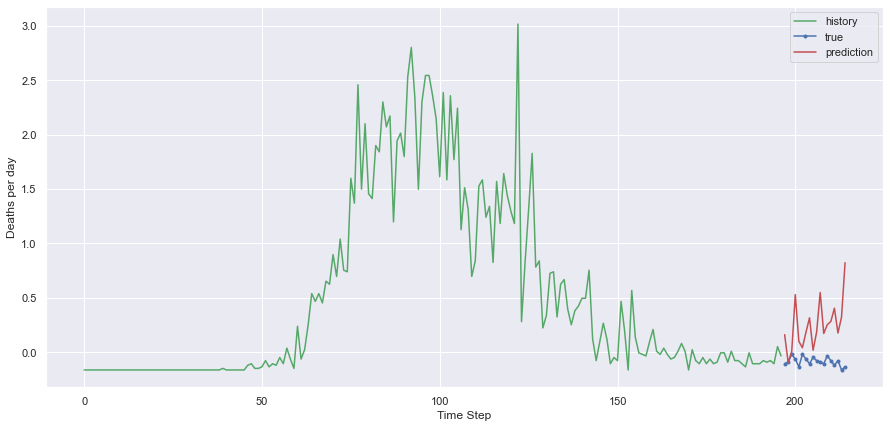

In [8]:
analyze("Canada")